In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [2]:
titles = pd.read_csv("./data/medium_post_titles.csv")
titles.subtitle = titles.subtitle.replace(np.nan, "")
titles.head()

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False
3,equality,"""Call me Nat Love"" :Black Cowboys and the Fron...",,False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False


In [3]:
n_truncated_subtitle = (titles.subtitle_truncated_flag == True).sum()
print("Number of entries with truncated subtutles: " + str(n_truncated_subtitle) + "/" + str(titles.shape[0]))

Number of entries with truncated subtutles: 43389/126418


There are a total number of 126,418 entries in the dataset. For each article title, it's assigned a category by Medium's system. In addition, the original data also include the subtitles. However, because subtiles can sometimes be very lengthy, it is truncated for some entries.

# Exploratory analysis and data wrangling

## Category frequency

Text(0.5, 1.0, 'Frequency Of Categories')

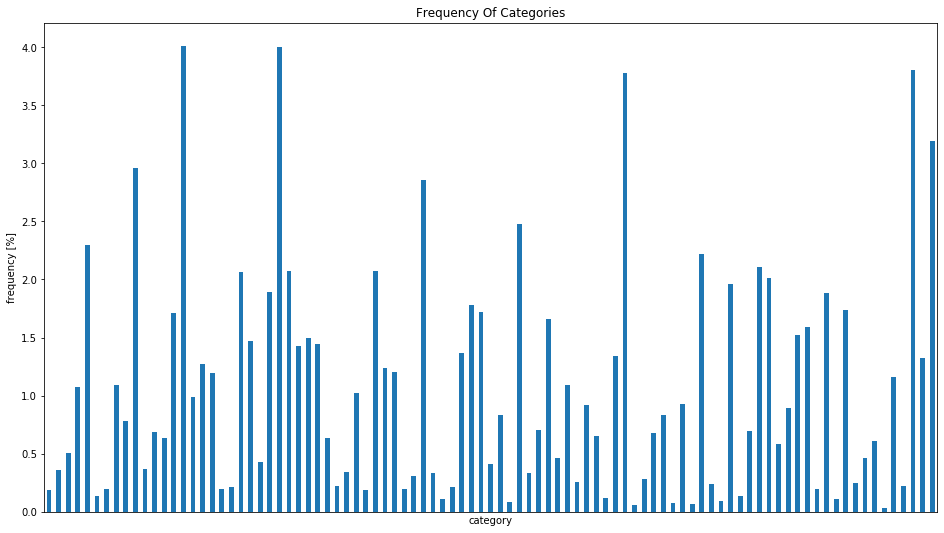

In [11]:
category_counts = titles["category"].value_counts().sort_index() / titles.shape[0] * 100

fig, ax = plt.subplots(figsize=(16,9))
category_counts.plot(kind="bar", ax=ax)
plt.xlabel("category")
plt.xticks([])
plt.ylim(bottom=0)
plt.ylabel("frequency [%]")
plt.title("Frequency Of Categories")

The dataset covers 93 categories assigned by Medium, and there is significance variance in terms of the number of entries for different categories.

In [4]:
titles_truncated = titles[titles.subtitle_truncated_flag].iloc[:, :3]
titles_nontruncated = titles[~titles.subtitle_truncated_flag].iloc[:, :3]

Text(0.5, 1.0, 'Frequency Of Categories')

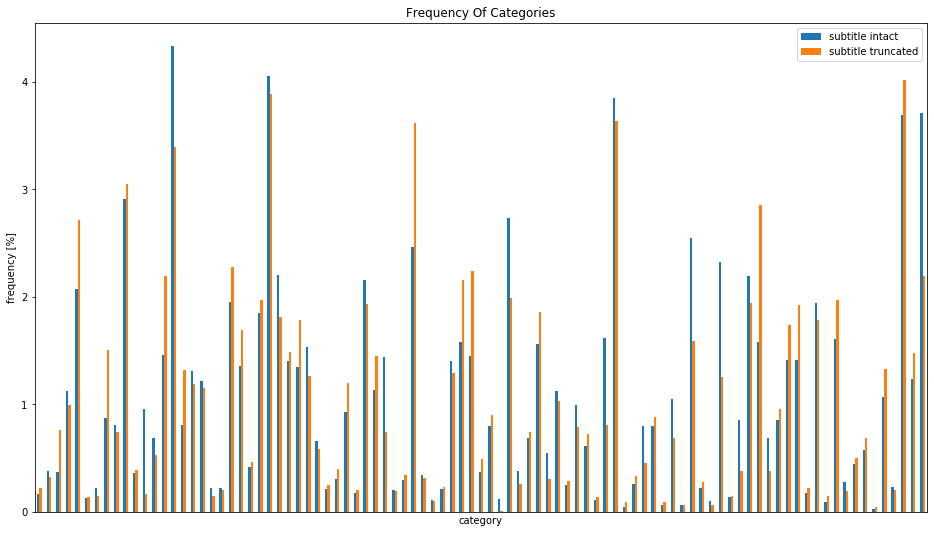

In [5]:
category_counts_truncated = titles_truncated["category"].value_counts().sort_index() / titles_truncated.shape[0] * 100
category_counts_nontruncated = titles_nontruncated["category"].value_counts().sort_index() / titles_nontruncated.shape[0] * 100
category_counts_combined = pd.concat([category_counts_nontruncated, category_counts_truncated], axis=1)
category_counts_combined.columns = ["subtitle intact", "subtitle truncated"]
category_list = category_counts_combined.index

fig, ax = plt.subplots(figsize=(16,9))
category_counts_combined.plot(kind="bar", ax=ax)
plt.legend()
plt.xlabel("category")
plt.xticks([])
plt.ylim(bottom=0)
plt.ylabel("frequency [%]")
plt.title("Frequency Of Categories")

Hoever, the frequency of different categories does not show apparent discrepancy between the truncated and non-truncated entries. Thus, in include as many entries as possible in the analysis, out approach will focus only on using the titles rather than the subtitles given that a significant number of them are not intact.

## Tokenization and vectorization

Using only the title, we can use TF-IDF to perform bag-of-words vectorization.
During this process, all letters are converted to lower case, and punctuation marks are gotten rid off.

In [6]:
import string

titles_nosub = titles.iloc[:, :2]
titles_nosub.title = titles_nosub.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles_nosub.title = titles_nosub.title.str.replace('‘', '')
titles_nosub.title = titles_nosub.title.str.replace('’', '')
titles_nosub.title = titles_nosub.title.str.replace('“', '')
titles_nosub.title = titles_nosub.title.str.replace('”', '')
titles_nosub.title = titles_nosub.title.str.replace('—', '')
titles_nosub.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer

vect = TfidfVectorizer()
tokenizer = TreebankWordTokenizer()
vect.set_params(tokenizer=tokenizer.tokenize)
vect.set_params(stop_words='english')
vect.set_params(ngram_range=(1, 2))
vect.set_params(min_df=2)
vect.set_params(max_df=0.5)

X = vect.fit_transform(titles_nosub.title)
vocabulary = np.array(vect.get_feature_names())

For each category, we can calculate the mean vector.

In [8]:
from tqdm import tqdm

most_significant_by_category = {}
average_significance_by_category_matrix = np.matrix([])
for c in tqdm(category_list):
    
    row_index = np.where(c == titles_nosub.category)
    X_c = X[row_index]
    
    average_significance = X_c.mean(axis=0)
    if average_significance_by_category_matrix.size == 0:
        average_significance_by_category_matrix = average_significance
    else:
        average_significance_by_category_matrix = np.concatenate([average_significance_by_category_matrix, average_significance])
    average_significance = average_significance.getA()[0]
    
    bag_of_words = vocabulary[average_significance > 0]
    average_significance = average_significance[average_significance > 0]
    sort_index = average_significance.argsort()[::-1]
    bag_of_words = bag_of_words[sort_index]
    average_significance = average_significance[sort_index]
    
    most_significant_by_category[c] = (bag_of_words, average_significance)
    

100%|██████████| 93/93 [00:02<00:00, 35.72it/s]


In [9]:
from wordcloud import WordCloud

def drawWordCloud(category, words,freq):
    
    word_freq = dict(zip(words, freq))
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freq)

    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    plt.title(category.upper(), fontsize=20)

The mean vector of TF-IDF scores for each category can be used to create a word cloud representation, where words that appear more often in the category have large font-size.

 For example,

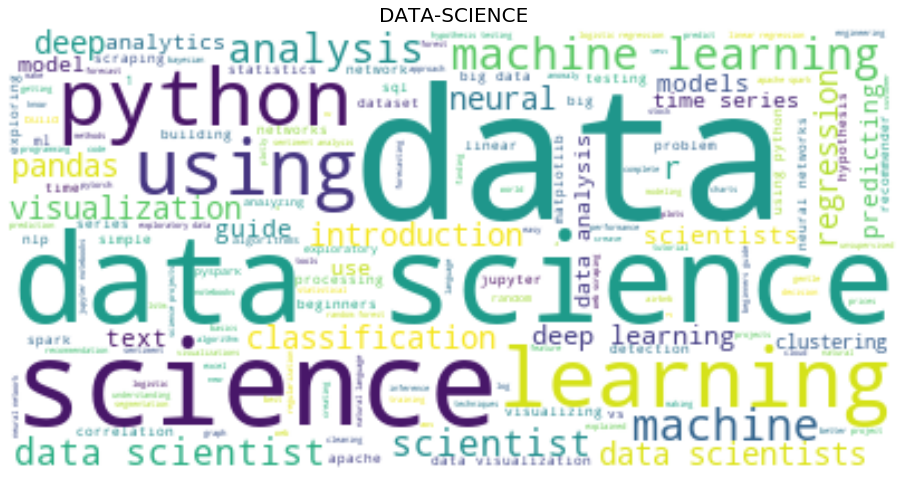

In [10]:
drawWordCloud("data-science", most_significant_by_category["data-science"][0], most_significant_by_category["data-science"][1])

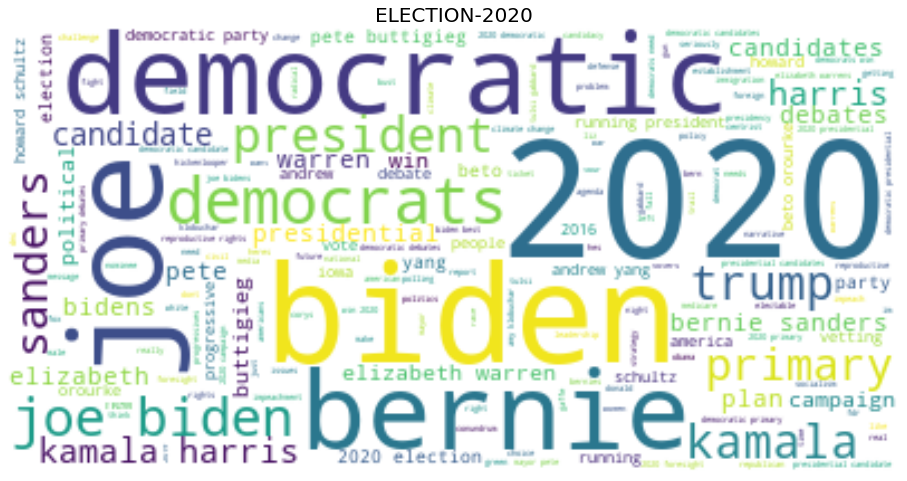

In [11]:
drawWordCloud("election-2020", most_significant_by_category["election-2020"][0], most_significant_by_category["election-2020"][1])

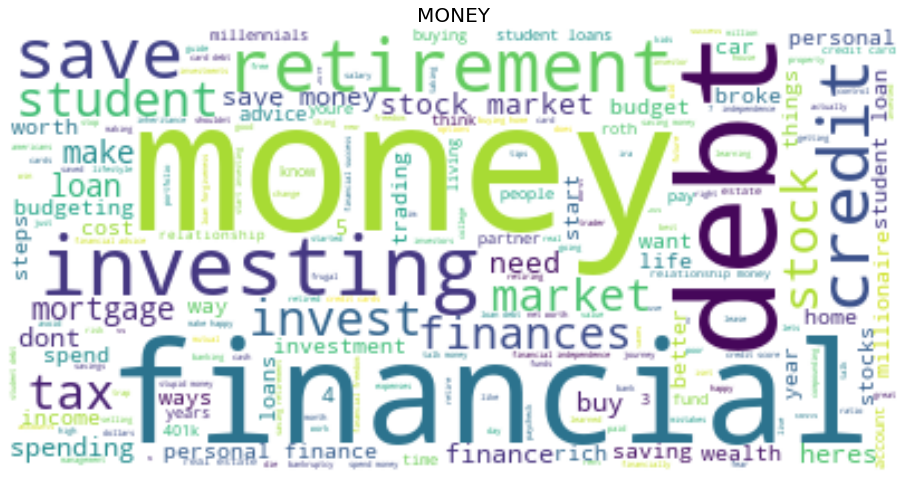

In [13]:
drawWordCloud("money", most_significant_by_category["money"][0], most_significant_by_category["money"][1])

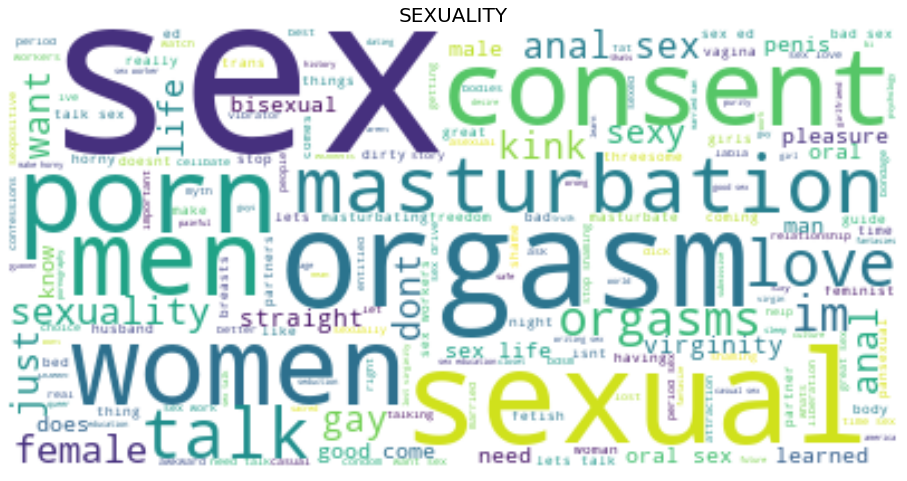

In [14]:
drawWordCloud("sexuality", most_significant_by_category["sexuality"][0], most_significant_by_category["sexuality"][1])

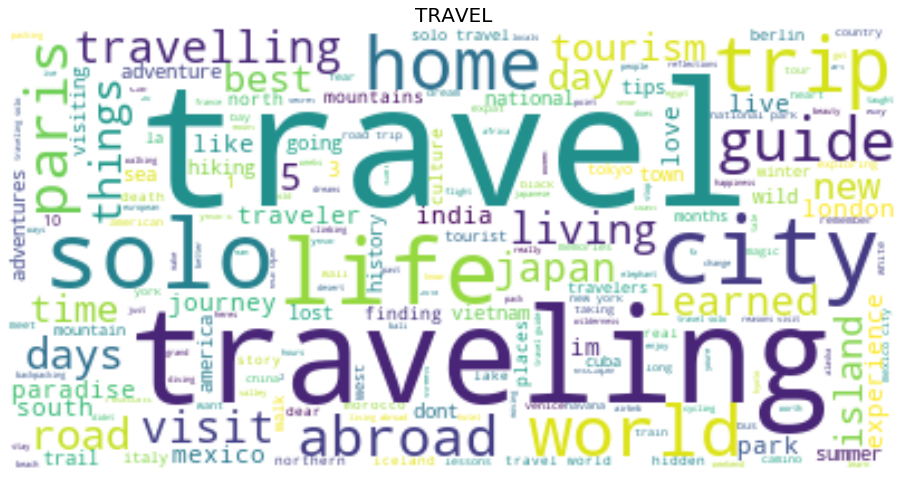

In [15]:
drawWordCloud("travel", most_significant_by_category["travel"][0], most_significant_by_category["travel"][1])

We can compute the similarity between the mean vector representation between each category.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similarity = cosine_similarity(average_significance_by_category_matrix)
cos_similarity_df = pd.DataFrame(cos_similarity, index=category_list, columns=category_list)

Cosine Similarity Between Categories


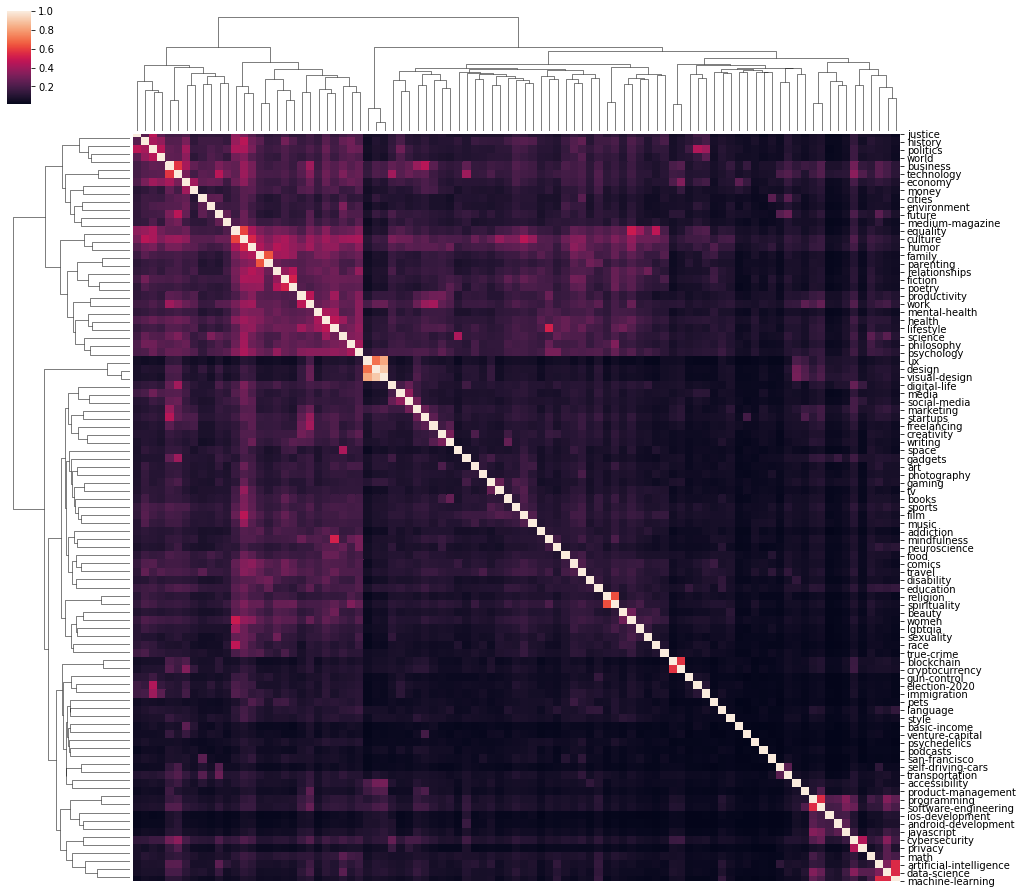

In [17]:
print("Cosine Similarity Between Categories")
ax = sns.clustermap(cos_similarity_df, method="complete", xticklabels=False,yticklabels=True, figsize=(16,16))

By ordering the cos-similarity matrix based on hierarchical linkage, we were able to group together categories with intuitive relations. For instance, _artificial-intelegence_, _data-science_ and _machine-learning_ formed a tight topic.

We can give each category a sequential integer label according to the above similarity.

In [18]:
from copy import deepcopy

ordered_category_index = ax.dendrogram_row.reordered_ind
ordered_category_list = deepcopy(category_list).values
for i, index_number in enumerate(ordered_category_index):
    ordered_category_list[i] = category_list[index_number]

# Dimension reduction

In [19]:
from sklearn.decomposition import TruncatedSVD 

pca = TruncatedSVD(n_components=1000)
pca.fit(X)

TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=5,
             random_state=None, tol=0.0)

Text(0.5, 1.0, 'Explained Variance')

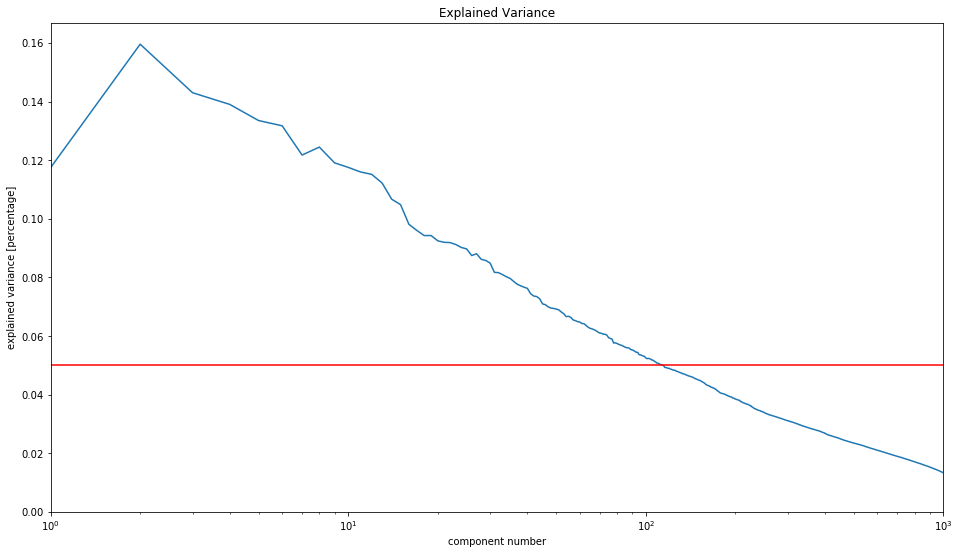

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(range(1, pca.n_components + 1), pca.explained_variance_ratio_ * 100)
ax.axhline(0.05, c="red")
plt.xscale("log")
plt.xlim([1, 1000])
plt.ylim(bottom=0)
plt.ylabel("explained variance [percentage]")
plt.xlabel("component number")
plt.title("Explained Variance")

SVD shows 100 components should be able to cover part of total variance in data with each dimension accounting for at least 0.05%. Hence, we try to reduce the dimensionality of vector representation to 100.

In [21]:
pca = TruncatedSVD(n_components=100)
X_reduced = pca.fit_transform(X)

In [22]:
average_significance_by_category_matrix = np.matrix([])
for c in tqdm(category_list):
    
    row_index = np.where(c == titles_nosub.category)
    X_c = X_reduced[row_index]
    
    
    average_significance = X_c.mean(axis=0).reshape([1, -1])
    if average_significance_by_category_matrix.size == 0:
        average_significance_by_category_matrix = average_significance
    else:
        average_significance_by_category_matrix = np.concatenate([average_significance_by_category_matrix, average_significance])

100%|██████████| 93/93 [00:00<00:00, 141.31it/s]


Cosine Similarity Between Categories


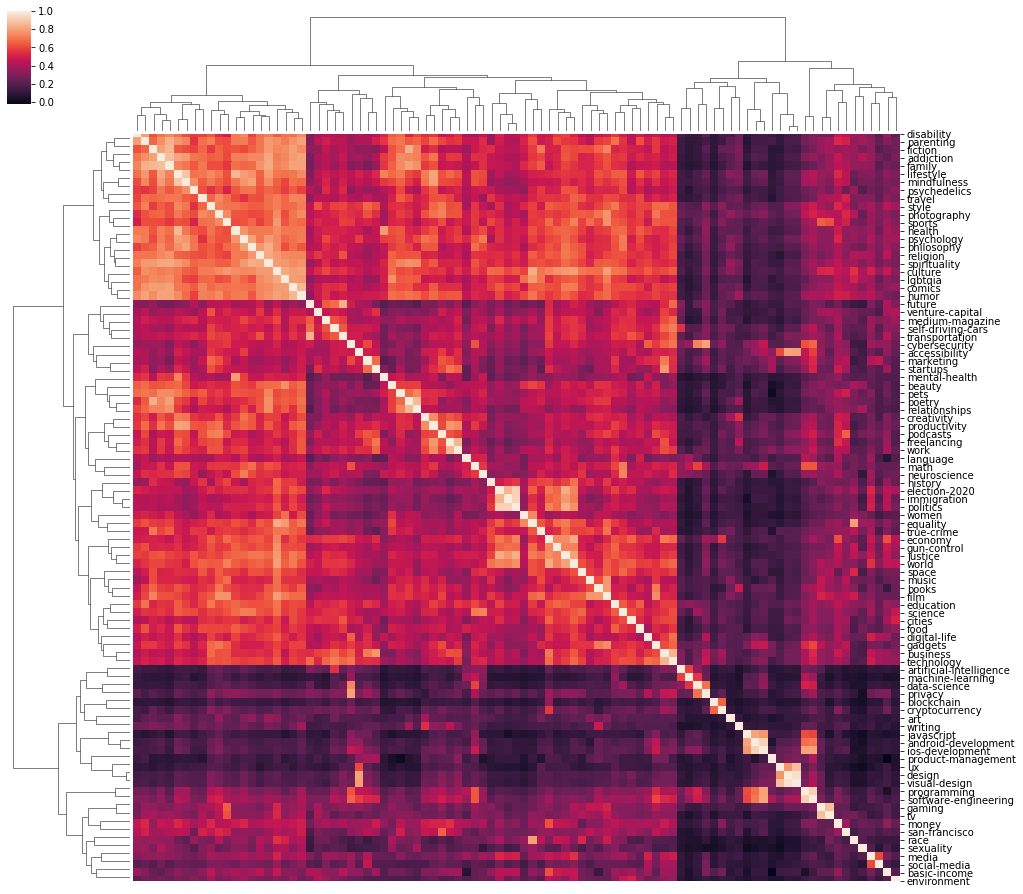

In [23]:
cos_similarity = cosine_similarity(average_significance_by_category_matrix)
cos_similarity_df = pd.DataFrame(cos_similarity, index=category_list, columns=category_list)

print("Cosine Similarity Between Categories")
ax = sns.clustermap(cos_similarity_df, method="complete", xticklabels=False,yticklabels=True, figsize=(16,16))

Using the low-dimension representation, we were still able to group tight topics based on cos-similarity. However, the ability to generalize topics that share higher-level resemblance is lost.

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
Y = tsne.fit_transform(X_reduced[:5000, :])

Text(0.5, 1.0, 'TSNE - 5000 samples')

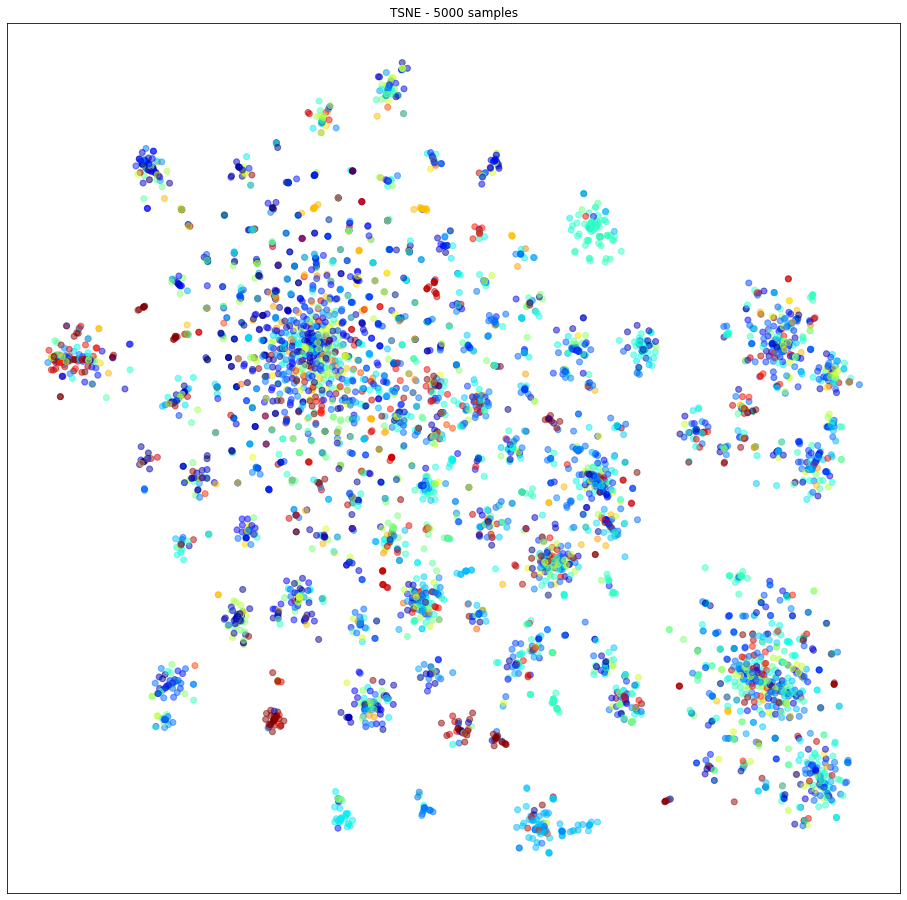

In [25]:
labels = np.array(titles_nosub.category[:5000].values)
for i, c in enumerate(ordered_category_list):
    labels[c == labels] = i
    
fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(Y[:, 0], Y[:, 1], c=labels, cmap="jet", alpha=0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
plt.title("TSNE - 5000 samples")

The above figure illustrates the result of TSNE. The data points, each of which represents a document, are colored such that categories with higher similarities (determined by cos-similarity ananlysis based on high-dimension data) are colored spectrally closer. The graph shows that we can still identigy some small clusters consisting of similar topics. Although, patterns on a larger scale failed to emerge.